In [16]:
from momentfm import MOMENTPipeline
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from tqdm import tqdm

model = MOMENTPipeline.from_pretrained(
    "AutonLab/MOMENT-1-large", 
    model_kwargs={"task_name": "reconstruction"},
)
model.init()

from momentfm.utils.utils import control_randomness
control_randomness(seed=13) # Set random seeds for PyTorch, Numpy etc.

In [18]:
device = "cuda:0" if torch.cuda.is_available() else "cpu"
device

'cuda:0'

In [19]:
# Create raw data with 288 length and 6 channels
raw_data = np.random.randn(288, 6)
print(f"Raw data shape: {raw_data.shape}")

Raw data shape: (288, 6)


In [20]:
# mask rondomly(5%) of each channel
masked_data = raw_data.copy()
mask_ratio = 0.05
for ch in range(masked_data.shape[1]):
    n_mask = int(mask_ratio * masked_data.shape[0])
    mask_indices = np.random.choice(masked_data.shape[0], n_mask, replace=False)
    masked_data[mask_indices, ch] = np.nan  # Assuming np.nan indicates missing data

In [21]:
import torch

# 1. Prepare data and handle NaNs
# Transpose to (6, 288) to treat each channel as a sequence
x = torch.tensor(masked_data.T).float() 
n_channels, seq_len = x.shape

# 2. Padding to 512 (MOMENT standard window size)
padding_len = 512 - seq_len
x_padded = torch.nn.functional.pad(x, (0, padding_len)) 
x_padded = x_padded.unsqueeze(1) # Shape: [batch_size, 1, window_size] -> (6, 1, 512)

# 3. Create masks
# input_mask: 1 for data, 0 for padding
input_mask = torch.zeros((n_channels, 512))
input_mask[:, :seq_len] = 1

# mask: 1 for masked positions (to be reconstructed)
# Use NaNs in the data as the mask for imputation
mask = torch.isnan(x_padded).long().squeeze(1) 

# Replace NaNs with 0 for the model input
x_padded = torch.nan_to_num(x_padded, nan=0.0)

# 4. Move to device and run inference
x_padded = x_padded.to(device)
input_mask = input_mask.to(device)
mask = mask.to(device)

model.to(device)
model.eval()

with torch.no_grad():
    output = model(x_enc=x_padded, input_mask=input_mask, mask=mask)

# 5. Extract and post-process reconstruction
# output.reconstruction shape: [6, 1, 512]
reconstruction = output.reconstruction.detach().cpu().numpy()
reconstruction = reconstruction.squeeze(1)[:, :seq_len].T # Back to (288, 6)

# 6. Fill missing values in imputed_data
imputed_data = masked_data.copy()
for ch in range(n_channels):
    nan_mask = np.isnan(masked_data[:, ch])
    imputed_data[nan_mask, ch] = reconstruction[nan_mask, ch]

print("Imputation completed.")
print(f"Original shape: {raw_data.shape}")
print(f"Imputed data shape: {imputed_data.shape}")
print(f"Remaining NaNs: {np.isnan(imputed_data).sum()}")

Imputation completed.
Original shape: (288, 6)
Imputed data shape: (288, 6)
Remaining NaNs: 0


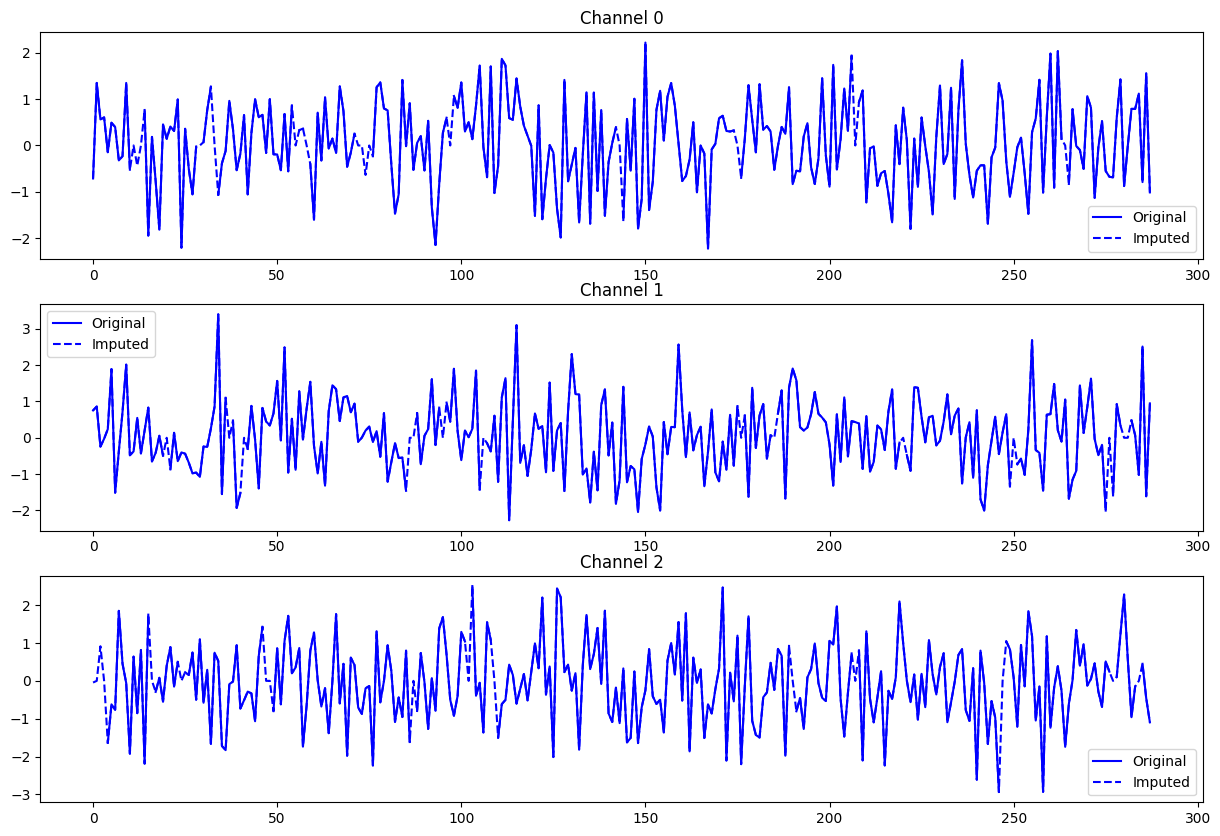

In [24]:
# show comparison
plt.figure(figsize=(15, 10))
channels_to_plot = [0, 1, 2]  # Plot first three channels
for i, ch in enumerate(channels_to_plot):
    plt.subplot(len(channels_to_plot), 1, i + 1)
    plt.plot(masked_data[:, ch], label='Original', color='blue')
    plt.plot(imputed_data[:, ch], label='Imputed', color='blue', linestyle='--')
    plt.title(f'Channel {ch}')
    plt.legend()